In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import requests
import hvplot.pandas
from pathlib import Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs,make_moons
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import r2_score
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2024-03-03 16:55:29.963974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Read in any csv files
funds_df = pd.read_csv(Path('../../bill-rates-2002-2023.csv'),
                           index_col='Date',
                           parse_dates=True,
                      infer_datetime_format=True)
funds_df = funds_df.dropna()   
funds_df

,4 WEEKS BANK DISCOUNT,4 WEEKS COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT,26 WEEKS BANK DISCOUNT,26 WEEKS COUPON EQUIVALENT,52 WEEKS BANK DISCOUNT,52 WEEKS COUPON EQUIVALENT
Date,,,,,,,,,,,,
2023-12-29,5.33,5.44,5.33,5.46,5.20,5.35,5.21,5.39,5.05,5.26,4.55,4.79
2023-12-28,5.31,5.42,5.29,5.42,5.25,5.41,5.22,5.40,5.06,5.28,4.58,4.82
2023-12-27,5.28,5.39,5.29,5.42,5.24,5.40,5.21,5.39,5.05,5.27,4.54,4.78
2023-12-26,5.27,5.38,5.27,5.40,5.25,5.41,5.22,5.40,5.06,5.28,4.58,4.82
2023-12-22,5.27,5.38,5.26,5.39,5.24,5.39,5.22,5.40,5.10,5.32,4.62,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,3.40,3.46,3.62,3.69,3.97,4.07,4.12,4.23,4.36,4.52,4.40,4.61
2022-10-24,3.42,3.48,3.65,3.72,4.00,4.10,4.14,4.26,4.38,4.54,4.40,4.61
2022-10-21,3.42,3.48,3.64,3.71,3.90,3.99,4.13,4.25,4.29,4.44,4.38,4.59


In [7]:
# Import API data
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [17]:
#3
# Load .env enviroment variables/
load_dotenv('alpaca_keys.env')

True

In [18]:
#4
# Set the tickers
tickers = ['SPY','EWA','EWC','EWJ','EWU','EWZ','EWW','EZU','IWM','MCHI']

# Create the shares DataFrame
df_etf = pd.DataFrame(index=tickers)

In [19]:
#5
# Set Alpaca API key and secret
alpaca_api_key = os.getenv('alpaca_key')
alpaca_secret_key = os.getenv('alpaca_secret_key')

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [20]:
#6
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [21]:
#6a
# Create current date variable
import datetime
today = datetime.date.today()
historical = today - datetime.timedelta(days=550)

In [22]:
#6b
# Format current date as ISO format
# Set start and end datetimes of 18 months
start_date = pd.Timestamp(historical, tz="America/New_York").isoformat()
end_date = pd.Timestamp(today, tz="America/New_York").isoformat()

In [23]:
#7
# Set timeframe to 1Day for the Alpaca API
timeframe = "1Day"


In [24]:
#8
# Get 18 months of pricing data for ETF portfolio
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date).df

df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-08-31 04:00:00+00:00,21.91,22.190,21.910,8650,22.14,3948736,22.029738,EWA
2022-09-01 04:00:00+00:00,21.73,21.805,21.530,6800,21.78,3012913,21.645007,EWA
2022-09-02 04:00:00+00:00,21.77,22.145,21.685,10128,22.02,5807035,21.911962,EWA
2022-09-06 04:00:00+00:00,21.47,21.675,21.425,10595,21.62,2796953,21.523252,EWA
2022-09-07 04:00:00+00:00,21.46,21.465,21.100,5996,21.10,2666228,21.326708,EWA
...,...,...,...,...,...,...,...,...
2024-02-26 05:00:00+00:00,505.99,508.750,505.860,434429,508.30,50386738,507.079425,SPY
2024-02-27 05:00:00+00:00,506.93,507.160,504.750,400260,506.70,48831828,506.231051,SPY
2024-02-28 05:00:00+00:00,506.26,506.855,504.960,420488,505.33,56506634,506.035403,SPY


In [25]:
# Drop time from index
df_portfolio.index = df_portfolio.index.date
df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
2022-08-31,21.91,22.190,21.910,8650,22.14,3948736,22.029738,EWA
2022-09-01,21.73,21.805,21.530,6800,21.78,3012913,21.645007,EWA
2022-09-02,21.77,22.145,21.685,10128,22.02,5807035,21.911962,EWA
2022-09-06,21.47,21.675,21.425,10595,21.62,2796953,21.523252,EWA
2022-09-07,21.46,21.465,21.100,5996,21.10,2666228,21.326708,EWA
...,...,...,...,...,...,...,...,...
2024-02-26,505.99,508.750,505.860,434429,508.30,50386738,507.079425,SPY
2024-02-27,506.93,507.160,504.750,400260,506.70,48831828,506.231051,SPY
2024-02-28,506.26,506.855,504.960,420488,505.33,56506634,506.035403,SPY
2024-02-29,508.08,509.740,505.350,547158,508.07,83883970,507.940683,SPY


In [26]:
# Separate ticker data
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol',axis=1)
EWA = df_portfolio[df_portfolio['symbol']=='EWA'].drop('symbol',axis=1)
EWC = df_portfolio[df_portfolio['symbol']=='EWC'].drop('symbol',axis=1)
EWJ = df_portfolio[df_portfolio['symbol']=='EWJ'].drop('symbol',axis=1)
EWU = df_portfolio[df_portfolio['symbol']=='EWU'].drop('symbol',axis=1)
EWZ = df_portfolio[df_portfolio['symbol']=='EWZ'].drop('symbol',axis=1)
EWW = df_portfolio[df_portfolio['symbol']=='EWW'].drop('symbol',axis=1)
EZU = df_portfolio[df_portfolio['symbol']=='EZU'].drop('symbol',axis=1)
IWM = df_portfolio[df_portfolio['symbol']=='IWM'].drop('symbol',axis=1)
MCHI = df_portfolio[df_portfolio['symbol']=='MCHI'].drop('symbol',axis=1)

In [27]:
# Concatenate tickers
ticker_portfolio = pd.concat([
    SPY,EWA,EWC,EWJ,EWU,EWZ,EWW,EZU,IWM,MCHI],axis=1,keys=[
    'SPY','EWA','EWC','EWJ','EWU','EWZ','EWW','EZU','IWM','MCHI'])
ticker_portfolio                                                           

SPY                                                  \
             close     high     low trade_count    open     volume   
2022-08-31  395.18  401.240  395.04      504194  399.93   77635142   
2022-09-01  396.42  396.780  390.04      597633  392.89   80204169   
2022-09-02  392.24  401.555  390.33      641089  400.28  101452968   
2022-09-06  390.76  394.120  388.42      559131  393.13   77511258   
2022-09-07  397.78  398.590  390.20      489059  390.43   73982489   
...            ...      ...     ...         ...     ...        ...   
2024-02-26  505.99  508.750  505.86      434429  508.30   50386738   
2024-02-27  506.93  507.160  504.75      400260  506.70   48831828   
2024-02-28  506.26  506.855  504.96      420488  505.33   56506634   
2024-02-29  508.08  509.740  505.35      547158  508.07   83883970   
2024-03-01  512.85  513.290  508.56      544947  508.98   77344853   

                          EWA                   ...     IWM            \
                  vwap  close    high      low  ...    open    volume   
2022-08-31  397.187287  21.91  22.190  21.9100  ...  184.94  22457303   
2022-09-01  393.107274  21.73  21.805  21.5300  ...  181.78  31305176   
2022-09-02  395.334927  21.77  22.145  21.6850  ...  183.60  27901838   
2022-09-06  391.261326  21.47  21.675  21.4250  ...  180.71  24579680   
2022-09-07  395.364409  21.46  21.465  21.1000  ...  177.97  25383387   
...                ...    ...     ...      ...  ...     ...       ...   
2024-02-26  507.079425  23.83  23.905  23.7550  ...  199.69  29118221   
2024-02-27  506.231051  23.99  24.010  23.9200  ...  203.08  32269825   
2024-02-28  506.035403  23.71  23.725  23.6490  ...  202.44  30143882   
2024-02-29  507.940683  23.92  24.000  23.7999  ...  205.18  40384628   
2024-03-01  511.227728  24.19  24.200  23.9000  ...  204.53  35156920   

                         MCHI                                               \
                  vwap  close     high     low trade_count   open   volume   
2022-08-31  184.087820  49.69  50.3250  49.530       35040  49.79  6156630   
2022-09-01  180.374139  49.22  49.3300  48.680       38620  49.15  5232575   
2022-09-02  181.465337  48.32  48.9300  48.265       27554  48.82  3199077   
2022-09-06  178.731439  47.39  47.9150  47.370       29728  47.90  3632619   
2022-09-07  180.524926  48.05  48.1100  47.350       28429  47.43  3880012   
...                ...    ...      ...     ...         ...    ...      ...   
2024-02-26  200.940151  39.55  39.8607  39.540       24944  39.67  7433109   
2024-02-27  203.564117  40.09  40.2000  40.015       23457  40.08  7335106   
2024-02-28  202.930565  38.91  39.2800  38.860       21181  39.28  5005620   
2024-02-29  204.093112  38.99  39.4000  38.920       22313  39.40  5122315   
2024-03-01  205.428085  39.63  39.7299  39.435       19030  39.51  4125589   

                       
                 vwap  
2022-08-31  49.787465  
2022-09-01  48.959277  
2022-09-02  48.541660  
2022-09-06  47.543434  
2022-09-07  47.738673  
...               ...  
2024-02-26  39.616831  
2024-02-27  40.099851  
2024-02-28  38.959974  
2024-02-29  39.105365  
2024-03-01  39.649950  

[377 rows x 70 columns]

In [28]:
# Drop timestamp from index
#ticker_portfolio.index = ticker_portfolio.index.date
ticker_portfolio

SPY                                                  \
             close     high     low trade_count    open     volume   
2022-08-31  395.18  401.240  395.04      504194  399.93   77635142   
2022-09-01  396.42  396.780  390.04      597633  392.89   80204169   
2022-09-02  392.24  401.555  390.33      641089  400.28  101452968   
2022-09-06  390.76  394.120  388.42      559131  393.13   77511258   
2022-09-07  397.78  398.590  390.20      489059  390.43   73982489   
...            ...      ...     ...         ...     ...        ...   
2024-02-26  505.99  508.750  505.86      434429  508.30   50386738   
2024-02-27  506.93  507.160  504.75      400260  506.70   48831828   
2024-02-28  506.26  506.855  504.96      420488  505.33   56506634   
2024-02-29  508.08  509.740  505.35      547158  508.07   83883970   
2024-03-01  512.85  513.290  508.56      544947  508.98   77344853   

                          EWA                   ...     IWM            \
                  vwap  close    high      low  ...    open    volume   
2022-08-31  397.187287  21.91  22.190  21.9100  ...  184.94  22457303   
2022-09-01  393.107274  21.73  21.805  21.5300  ...  181.78  31305176   
2022-09-02  395.334927  21.77  22.145  21.6850  ...  183.60  27901838   
2022-09-06  391.261326  21.47  21.675  21.4250  ...  180.71  24579680   
2022-09-07  395.364409  21.46  21.465  21.1000  ...  177.97  25383387   
...                ...    ...     ...      ...  ...     ...       ...   
2024-02-26  507.079425  23.83  23.905  23.7550  ...  199.69  29118221   
2024-02-27  506.231051  23.99  24.010  23.9200  ...  203.08  32269825   
2024-02-28  506.035403  23.71  23.725  23.6490  ...  202.44  30143882   
2024-02-29  507.940683  23.92  24.000  23.7999  ...  205.18  40384628   
2024-03-01  511.227728  24.19  24.200  23.9000  ...  204.53  35156920   

                         MCHI                                               \
                  vwap  close     high     low trade_count   open   volume   
2022-08-31  184.087820  49.69  50.3250  49.530       35040  49.79  6156630   
2022-09-01  180.374139  49.22  49.3300  48.680       38620  49.15  5232575   
2022-09-02  181.465337  48.32  48.9300  48.265       27554  48.82  3199077   
2022-09-06  178.731439  47.39  47.9150  47.370       29728  47.90  3632619   
2022-09-07  180.524926  48.05  48.1100  47.350       28429  47.43  3880012   
...                ...    ...      ...     ...         ...    ...      ...   
2024-02-26  200.940151  39.55  39.8607  39.540       24944  39.67  7433109   
2024-02-27  203.564117  40.09  40.2000  40.015       23457  40.08  7335106   
2024-02-28  202.930565  38.91  39.2800  38.860       21181  39.28  5005620   
2024-02-29  204.093112  38.99  39.4000  38.920       22313  39.40  5122315   
2024-03-01  205.428085  39.63  39.7299  39.435       19030  39.51  4125589   

                       
                 vwap  
2022-08-31  49.787465  
2022-09-01  48.959277  
2022-09-02  48.541660  
2022-09-06  47.543434  
2022-09-07  47.738673  
...               ...  
2024-02-26  39.616831  
2024-02-27  40.099851  
2024-02-28  38.959974  
2024-02-29  39.105365  
2024-03-01  39.649950  

[377 rows x 70 columns]

In [29]:
# Create a dataframe for closing prices
ticker_close = pd.DataFrame()
ticker_close['SPY Close'] = ticker_portfolio['SPY']['close']
ticker_close['EWA Close'] = ticker_portfolio['EWA']['close']
ticker_close['EWC Close'] = ticker_portfolio['EWC']['close']
ticker_close['EWJ Close'] = ticker_portfolio['EWJ']['close']
ticker_close['EWU Close'] = ticker_portfolio['EWU']['close']
ticker_close['EWZ Close'] = ticker_portfolio['EWZ']['close']
ticker_close['EWW Close'] = ticker_portfolio['EWW']['close']
ticker_close['EZU Close'] = ticker_portfolio['EZU']['close']
ticker_close['IWM Close'] = ticker_portfolio['EWA']['close']
ticker_close['MCHI Close'] = ticker_portfolio['MCHI']['close']
ticker_close = ticker_close.dropna()
ticker_close

,SPY Close,EWA Close,EWC Close,EWJ Close,EWU Close,EWZ Close,EWW Close,EZU Close,IWM Close,MCHI Close
2022-08-31,395.18,21.91,33.69,53.59,28.91,30.52,44.25,35.33,21.91,49.69
2022-09-01,396.42,21.73,33.36,52.95,28.42,30.46,44.68,34.80,21.73,49.22
2022-09-02,392.24,21.77,33.66,52.37,28.41,30.87,45.58,34.46,21.77,48.32
2022-09-06,390.76,21.47,33.28,51.55,28.66,30.25,45.00,34.56,21.47,47.39
2022-09-07,397.78,21.46,33.67,51.47,28.63,30.53,45.49,35.30,21.46,48.05
...,...,...,...,...,...,...,...,...,...,...
2024-02-26,505.99,23.83,36.85,69.00,32.91,33.29,66.17,48.99,23.83,39.55
2024-02-27,506.93,23.99,36.76,69.18,32.93,34.08,66.12,49.17,23.99,40.09
2024-02-28,506.26,23.71,36.54,68.67,32.58,33.35,64.89,49.07,23.71,38.91
2024-02-29,508.08,23.92,36.77,69.12,32.75,33.01,65.24,49.05,23.92,38.99


In [30]:
# Create dataframe for training on historical data (X features)
historical_df = ticker_close['SPY Close']
historical_df

2022-08-31    395.18
2022-09-01    396.42
2022-09-02    392.24
2022-09-06    390.76
2022-09-07    397.78
               ...  
2024-02-26    505.99
2024-02-27    506.93
2024-02-28    506.26
2024-02-29    508.08
2024-03-01    512.85
Name: SPY Close, Length: 377, dtype: float64

In [31]:
# Determine correlation between SPY and ETFs
ticker_close[[
    'SPY Close','EWA Close','EWC Close','EWJ Close','EWU Close',
    'EWZ Close','EWW Close', 'EZU Close','IWM Close','MCHI Close']].corr().style.background_gradient()


,SPY Close,EWA Close,EWC Close,EWJ Close,EWU Close,EWZ Close,EWW Close,EZU Close,IWM Close,MCHI Close
SPY Close,1.000000,0.462532,0.738005,0.941326,0.604276,0.639137,0.866246,0.771163,0.462532,-0.462902
EWA Close,0.462532,1.000000,0.866570,0.557755,0.777909,0.057371,0.618061,0.739857,1.000000,0.313918
EWC Close,0.738005,0.866570,1.000000,0.742010,0.753049,0.399267,0.769392,0.785154,0.866570,-0.026199
EWJ Close,0.941326,0.557755,0.742010,1.000000,0.773662,0.458282,0.928418,0.893956,0.557755,-0.266184
EWU Close,0.604276,0.777909,0.753049,0.773662,1.000000,0.024007,0.823963,0.946766,0.777909,0.242455
EWZ Close,0.639137,0.057371,0.399267,0.458282,0.024007,1.000000,0.429790,0.188668,0.057371,-0.622717
EWW Close,0.866246,0.618061,0.769392,0.928418,0.823963,0.429790,1.000000,0.940638,0.618061,-0.214110
EZU Close,0.771163,0.739857,0.785154,0.893956,0.946766,0.188668,0.940638,1.000000,0.739857,0.034591
IWM Close,0.462532,1.000000,0.866570,0.557755,0.777909,0.057371,0.618061,0.739857,1.000000,0.313918
MCHI Close,-0.462902,0.313918,-0.026199,-0.266184,0.242455,-0.622717,-0.214110,0.034591,0.313918,1.000000


In [32]:
# View ticker correlation in dataframe
corr_df = ticker_close[[
    'SPY Close','EWA Close','EWC Close','EWJ Close','EWU Close',
    'EWZ Close','EWW Close', 'EZU Close','IWM Close','MCHI Close']].corr()
print(corr_df)

            SPY Close  EWA Close  EWC Close  EWJ Close  EWU Close  EWZ Close  \
SPY Close    1.000000   0.462532   0.738005   0.941326   0.604276   0.639137   
EWA Close    0.462532   1.000000   0.866570   0.557755   0.777909   0.057371   
EWC Close    0.738005   0.866570   1.000000   0.742010   0.753049   0.399267   
EWJ Close    0.941326   0.557755   0.742010   1.000000   0.773662   0.458282   
EWU Close    0.604276   0.777909   0.753049   0.773662   1.000000   0.024007   
EWZ Close    0.639137   0.057371   0.399267   0.458282   0.024007   1.000000   
EWW Close    0.866246   0.618061   0.769392   0.928418   0.823963   0.429790   
EZU Close    0.771163   0.739857   0.785154   0.893956   0.946766   0.188668   
IWM Close    0.462532   1.000000   0.866570   0.557755   0.777909   0.057371   
MCHI Close  -0.462902   0.313918  -0.026199  -0.266184   0.242455  -0.622717   

            EWW Close  EZU Close  IWM Close  MCHI Close  
SPY Close    0.866246   0.771163   0.462532   -0.462902  
EWA

In [33]:
# Drop unnecessary columns
funds_df_2 = funds_df.drop(columns=['4 WEEKS BANK DISCOUNT','4 WEEKS COUPON EQUIVALENT',
                                           '8 WEEKS BANK DISCOUNT', '8 WEEKS COUPON EQUIVALENT',
                                           '13 WEEKS BANK DISCOUNT', '13 WEEKS COUPON EQUIVALENT',
                                           '17 WEEKS BANK DISCOUNT', '17 WEEKS COUPON EQUIVALENT',
                                           '26 WEEKS BANK DISCOUNT', '26 WEEKS COUPON EQUIVALENT', 
                                            '52 WEEKS COUPON EQUIVALENT'])
funds_df_2

,52 WEEKS BANK DISCOUNT
Date,
2023-12-29,4.55
2023-12-28,4.58
2023-12-27,4.54
2023-12-26,4.58
2023-12-22,4.62
...,...
2022-10-25,4.40
2022-10-24,4.40
2022-10-21,4.38


In [34]:
# Rename '52 WEEKS' column
funds_df_2['Fed Interest Rates'] = funds_df_2['52 WEEKS BANK DISCOUNT']
funds_df_2 = funds_df_2.drop(columns=['52 WEEKS BANK DISCOUNT'])
funds_df_2

,Fed Interest Rates
Date,
2023-12-29,4.55
2023-12-28,4.58
2023-12-27,4.54
2023-12-26,4.58
2023-12-22,4.62
...,...
2022-10-25,4.40
2022-10-24,4.40
2022-10-21,4.38


In [35]:
# Create a list to hold correlated etfs and respective symbols
# Create for loop to append highest correlated etfs in respective list
correlated_etfs = []
symbols = []
for index,df in corr_df.iterrows():
    if index == 'SPY Close':
        continue 
    if df['SPY Close'] >= .67:
        correlated_etfs.append(df['SPY Close'])
        symbols.append(index)
       
print(correlated_etfs)
print(symbols)

[0.7380052619998642, 0.9413258717279276, 0.8662462082052381, 0.771162661974003]
['EWC Close', 'EWJ Close', 'EWW Close', 'EZU Close']


In [36]:
# Set trading parameters
symbol_df = ticker_close[symbols].copy() 
symbol_df['EWJ Returns'] = symbol_df['EWJ Close'].pct_change()
symbol_df['EWW Returns'] = symbol_df['EWW Close'].pct_change()
symbol_df['EZU Returns'] = symbol_df['EZU Close'].pct_change()
symbol_df['EWC Returns'] = symbol_df['EWC Close'].pct_change()
symbol_df = symbol_df.dropna()
symbol_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns
2022-09-01,33.36,52.95,44.68,34.80,-0.011943,0.009718,-0.015001,-0.009795
2022-09-02,33.66,52.37,45.58,34.46,-0.010954,0.020143,-0.009770,0.008993
2022-09-06,33.28,51.55,45.00,34.56,-0.015658,-0.012725,0.002902,-0.011289
2022-09-07,33.67,51.47,45.49,35.30,-0.001552,0.010889,0.021412,0.011719
2022-09-08,34.04,52.09,45.88,35.13,0.012046,0.008573,-0.004816,0.010989
...,...,...,...,...,...,...,...,...
2024-02-26,36.85,69.00,66.17,48.99,-0.000145,-0.005411,-0.000408,-0.003785
2024-02-27,36.76,69.18,66.12,49.17,0.002609,-0.000756,0.003674,-0.002442
2024-02-28,36.54,68.67,64.89,49.07,-0.007372,-0.018603,-0.002034,-0.005985
2024-02-29,36.77,69.12,65.24,49.05,0.006553,0.005394,-0.000408,0.006294


In [37]:
# Save a new copy of symbol_df into features_df and begin adding more features
features_df = symbol_df.copy()
features_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns
2022-09-01,33.36,52.95,44.68,34.80,-0.011943,0.009718,-0.015001,-0.009795
2022-09-02,33.66,52.37,45.58,34.46,-0.010954,0.020143,-0.009770,0.008993
2022-09-06,33.28,51.55,45.00,34.56,-0.015658,-0.012725,0.002902,-0.011289
2022-09-07,33.67,51.47,45.49,35.30,-0.001552,0.010889,0.021412,0.011719
2022-09-08,34.04,52.09,45.88,35.13,0.012046,0.008573,-0.004816,0.010989
...,...,...,...,...,...,...,...,...
2024-02-26,36.85,69.00,66.17,48.99,-0.000145,-0.005411,-0.000408,-0.003785
2024-02-27,36.76,69.18,66.12,49.17,0.002609,-0.000756,0.003674,-0.002442
2024-02-28,36.54,68.67,64.89,49.07,-0.007372,-0.018603,-0.002034,-0.005985
2024-02-29,36.77,69.12,65.24,49.05,0.006553,0.005394,-0.000408,0.006294


In [38]:
# Add SPY closing price daily returns to features dataframe
features_df['SPY Returns'] = ticker_close['SPY Close'].pct_change()
features_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns,SPY Returns
2022-09-01,33.36,52.95,44.68,34.80,-0.011943,0.009718,-0.015001,-0.009795,0.003138
2022-09-02,33.66,52.37,45.58,34.46,-0.010954,0.020143,-0.009770,0.008993,-0.010544
2022-09-06,33.28,51.55,45.00,34.56,-0.015658,-0.012725,0.002902,-0.011289,-0.003773
2022-09-07,33.67,51.47,45.49,35.30,-0.001552,0.010889,0.021412,0.011719,0.017965
2022-09-08,34.04,52.09,45.88,35.13,0.012046,0.008573,-0.004816,0.010989,0.006536
...,...,...,...,...,...,...,...,...,...
2024-02-26,36.85,69.00,66.17,48.99,-0.000145,-0.005411,-0.000408,-0.003785,-0.003662
2024-02-27,36.76,69.18,66.12,49.17,0.002609,-0.000756,0.003674,-0.002442,0.001858
2024-02-28,36.54,68.67,64.89,49.07,-0.007372,-0.018603,-0.002034,-0.005985,-0.001322
2024-02-29,36.77,69.12,65.24,49.05,0.006553,0.005394,-0.000408,0.006294,0.003595


In [39]:
# Incorporate federal funds rate DF as a feature in features_df
features_df['Fed Funds Rate'] = funds_df_2
features_df = features_df.dropna()
features_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns,SPY Returns,Fed Funds Rate
2022-10-19,31.33,48.48,46.02,33.48,-0.006150,-0.005403,-0.014715,-0.007602,-0.007086,4.39
2022-10-20,31.17,48.44,46.28,33.49,-0.000825,0.005650,0.000299,-0.005107,-0.008385,4.44
2022-10-21,31.96,49.29,47.43,34.16,0.017547,0.024849,0.020006,0.025345,0.024301,4.38
2022-10-24,31.89,48.97,48.06,34.47,-0.006492,0.013283,0.009075,-0.002190,0.012237,4.40
2022-10-25,32.43,50.09,49.04,35.33,0.022871,0.020391,0.024949,0.016933,0.015969,4.40
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,36.43,63.33,67.81,47.23,0.003168,-0.000590,-0.001691,0.007467,0.002010,4.62
2023-12-26,36.83,63.31,68.31,47.57,-0.000316,0.007374,0.007199,0.010980,0.004223,4.58
2023-12-27,36.87,63.66,68.46,47.81,0.005528,0.002196,0.005045,0.001086,0.001808,4.54
2023-12-28,36.70,64.04,67.96,47.41,0.005969,-0.007304,-0.008366,-0.004611,0.000378,4.58


In [40]:
# Rearrange columns
features_df = features_df.iloc[:,[0,1,2,3,4,5,6,7,9,8]]
features_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns,Fed Funds Rate,SPY Returns
2022-10-19,31.33,48.48,46.02,33.48,-0.006150,-0.005403,-0.014715,-0.007602,4.39,-0.007086
2022-10-20,31.17,48.44,46.28,33.49,-0.000825,0.005650,0.000299,-0.005107,4.44,-0.008385
2022-10-21,31.96,49.29,47.43,34.16,0.017547,0.024849,0.020006,0.025345,4.38,0.024301
2022-10-24,31.89,48.97,48.06,34.47,-0.006492,0.013283,0.009075,-0.002190,4.40,0.012237
2022-10-25,32.43,50.09,49.04,35.33,0.022871,0.020391,0.024949,0.016933,4.40,0.015969
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,36.43,63.33,67.81,47.23,0.003168,-0.000590,-0.001691,0.007467,4.62,0.002010
2023-12-26,36.83,63.31,68.31,47.57,-0.000316,0.007374,0.007199,0.010980,4.58,0.004223
2023-12-27,36.87,63.66,68.46,47.81,0.005528,0.002196,0.005045,0.001086,4.54,0.001808
2023-12-28,36.70,64.04,67.96,47.41,0.005969,-0.007304,-0.008366,-0.004611,4.58,0.000378


In [41]:
# Add "y" column (SPY historical closing price) for testing neural models
features_df['y'] = 0
features_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns,Fed Funds Rate,SPY Returns,y
2022-10-19,31.33,48.48,46.02,33.48,-0.006150,-0.005403,-0.014715,-0.007602,4.39,-0.007086,0
2022-10-20,31.17,48.44,46.28,33.49,-0.000825,0.005650,0.000299,-0.005107,4.44,-0.008385,0
2022-10-21,31.96,49.29,47.43,34.16,0.017547,0.024849,0.020006,0.025345,4.38,0.024301,0
2022-10-24,31.89,48.97,48.06,34.47,-0.006492,0.013283,0.009075,-0.002190,4.40,0.012237,0
2022-10-25,32.43,50.09,49.04,35.33,0.022871,0.020391,0.024949,0.016933,4.40,0.015969,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,36.43,63.33,67.81,47.23,0.003168,-0.000590,-0.001691,0.007467,4.62,0.002010,0
2023-12-26,36.83,63.31,68.31,47.57,-0.000316,0.007374,0.007199,0.010980,4.58,0.004223,0
2023-12-27,36.87,63.66,68.46,47.81,0.005528,0.002196,0.005045,0.001086,4.54,0.001808,0
2023-12-28,36.70,64.04,67.96,47.41,0.005969,-0.007304,-0.008366,-0.004611,4.58,0.000378,0


In [42]:
# Set trading parameters
features_df.loc[features_df['SPY Returns'] > 0.005,'y'] = 1
features_df.loc[features_df['SPY Returns'] < -0.005,'y'] = -1
features_df

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns,Fed Funds Rate,SPY Returns,y
2022-10-19,31.33,48.48,46.02,33.48,-0.006150,-0.005403,-0.014715,-0.007602,4.39,-0.007086,-1
2022-10-20,31.17,48.44,46.28,33.49,-0.000825,0.005650,0.000299,-0.005107,4.44,-0.008385,-1
2022-10-21,31.96,49.29,47.43,34.16,0.017547,0.024849,0.020006,0.025345,4.38,0.024301,1
2022-10-24,31.89,48.97,48.06,34.47,-0.006492,0.013283,0.009075,-0.002190,4.40,0.012237,1
2022-10-25,32.43,50.09,49.04,35.33,0.022871,0.020391,0.024949,0.016933,4.40,0.015969,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,36.43,63.33,67.81,47.23,0.003168,-0.000590,-0.001691,0.007467,4.62,0.002010,0
2023-12-26,36.83,63.31,68.31,47.57,-0.000316,0.007374,0.007199,0.010980,4.58,0.004223,0
2023-12-27,36.87,63.66,68.46,47.81,0.005528,0.002196,0.005045,0.001086,4.54,0.001808,0
2023-12-28,36.70,64.04,67.96,47.41,0.005969,-0.007304,-0.008366,-0.004611,4.58,0.000378,0


In [43]:
# Set X (these are the initial features for neural network)
# Create a shift (lag) to verify effect of correlation on SPY Returns 
X = features_df[['EWC Close','EWJ Close','EWW Close','EZU Close',
                 'EWJ Returns','EWW Returns','EZU Returns','EWC Returns',
                 'Fed Funds Rate','SPY Returns']].shift().dropna().copy()
X.head(3)

,EWC Close,EWJ Close,EWW Close,EZU Close,EWJ Returns,EWW Returns,EZU Returns,EWC Returns,Fed Funds Rate,SPY Returns
2022-10-20,31.33,48.48,46.02,33.48,-0.006150,-0.005403,-0.014715,-0.007602,4.39,-0.007086
2022-10-21,31.17,48.44,46.28,33.49,-0.000825,0.005650,0.000299,-0.005107,4.44,-0.008385
2022-10-24,31.96,49.29,47.43,34.16,0.017547,0.024849,0.020006,0.025345,4.38,0.024301


In [44]:
y = features_df['y']
y = y.iloc[1:]
y

2022-10-20   -1
2022-10-21    1
2022-10-24    1
2022-10-25    1
2022-10-26   -1
             ..
2023-12-22    0
2023-12-26    0
2023-12-27    0
2023-12-28    0
2023-12-29    0
Name: y, Length: 298, dtype: int64

In [45]:
# import libraries (potentially remove this block of code if redundant)
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [47]:
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [48]:
number_inputs = 10
number_hidden_nodes = 5
neuron = Sequential()
neuron.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))
# Add the output layer to the model specifying the number of output neurons and activation function
neuron.add(Dense(3, activation="relu"))


In [49]:
neuron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 55        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# Compile the Sequential model
neuron.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [51]:
# Fit the model using 100 epochs and the training data
model = neuron.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
7/7 [==============================] - 1s 5ms/step - loss: 0.9768 - accuracy: 0.0762
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.9293 - accuracy: 0.0897
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.8902 - accuracy: 0.0897
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 0.8547 - accuracy: 0.1076
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.8237 - accuracy: 0.1121
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 0.7946 - accuracy: 0.1166
Epoch 7/200
7/7 [==============================] - 0s 5ms/step - loss: 0.7696 - accuracy: 0.1256
Epoch 8/200
7/7 [==============================] - 0s 5ms/step - loss: 0.7483 - accuracy: 0.1345
Epoch 9/200
7/7 [==============================] - 0s 4ms/step - loss: 0.7269 - accuracy: 0.1390
Epoch 10/200
7/7 [==============================] - 0s 5ms/step - loss: 0.7109 - accuracy: 0.1480
Epoch 11/200
7/7 [===========

<Axes: >

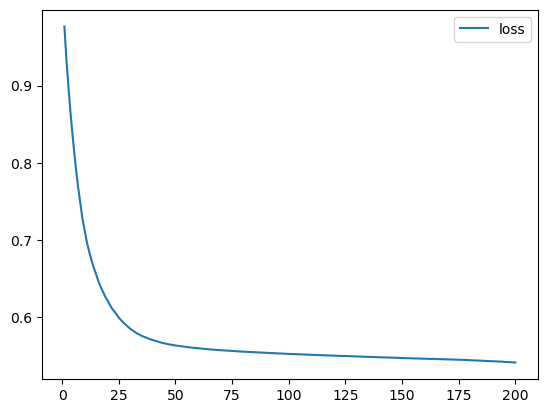

In [60]:
# Create a DataFrame using the model history and an index parameter
model_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))
# Vizualize the model plot where the y-axis displays the loss metric
model_plot.plot(y="loss")

<Axes: >

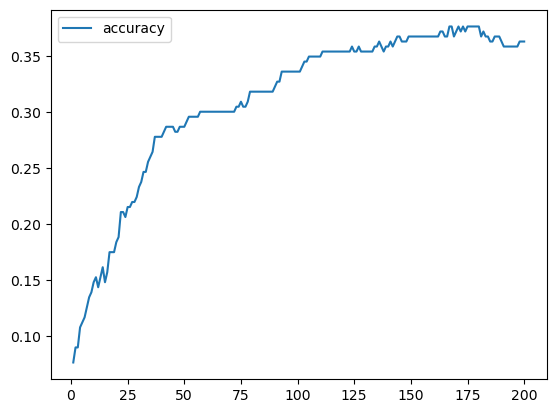

In [61]:
# Vizualize the model plot where the y-axis displays the accuracy metric
model_plot.plot(y="accuracy")

In [62]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)
# Display the evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - loss: 0.5397 - accuracy: 0.4133 - 47ms/epoch - 16ms/step
Loss: 0.5397329926490784, Accuracy: 0.41333332657814026


In [55]:
# Save model in JSON format
nn_json = neuron.to_json()

# Define a relative path to save the model
# The model should be saved with a .json file extension
file_path = Path("/Users/khareemhenderson/Desktop/project_2/AlgorithmicSpy/resources/model.json")

# Write the model to the the file 
with open(file_path, "w") as json_file:
    json_file.write(nn_json)

# Define a relative path to save the model weights
# The model weights should be saved with a .keras file extension
file_path = "/Users/khareemhenderson/Desktop/project_2/AlgorithmicSpy/resources/model.keras"

# Save the weights to the file path
neuron.save_weights(file_path)


In [56]:
# Load the model to predict values
from tensorflow.keras.models import model_from_json
# Identify the relative path of the model's location
file_path = Path('/Users/khareemhenderson/Desktop/project_2/AlgorithmicSpy/resources/model.json')

# Read in the model and save it as the variable loaded_model
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# Identify the relative path for the model's weights
file_path = "/Users/khareemhenderson/Desktop/project_2/AlgorithmicSpy/resources/model.keras"

# Load the model's weights to the variable loaded_model
loaded_model.load_weights(file_path)

In [57]:
# Predict values using the testing data
y_pred = loaded_model.predict(X_test_scaled)

# View the model's predictions
y_pred[:5, :]

3/3 [==============================] - 0s 3ms/step


array([[0.        , 0.        , 0.        ],
       [0.        , 0.09047063, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.0237222 , 0.        ]], dtype=float32)

In [64]:
y_pred_df = pd.DataFrame(y_pred,columns=['Prediction 1','Prediction 2','Prediction 3'])
y_pred_df

,Prediction 1,Prediction 2,Prediction 3
0,0.000000,0.000000,0.000000
1,0.000000,0.090471,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.023722,0.000000
...,...,...,...
70,0.000000,0.000000,0.000000
71,0.000000,0.461153,0.632887
72,0.004823,0.000000,0.000000
73,0.000000,0.000000,0.000000
